### Larissa de Santi -  Challenge 4: Crop Questions Analysis

For Challenge 4, I initiated an unsupervised learning pipeline on a sample of the 7.6M+ multilingual question dataset. I used the "paraphrase-multilingual-mpnet-base-v2" model to generate semantic embeddings and cluster the questions into topic groups. However, I discovered that the K-Means clustering (K=3) grouped questions primarily by language rather than by topic, confirming the challenge of aligning low-resource languages. As a result, I am shifting the strategy to monolingual clustering on the English subset to establish reliable topic labels for the final classification.

In [ ]:
# Library imports
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load a sample of the dataset for verification
file_path = 'producers_direct_dataset.csv'
sample_size = 50
sample_df = pd.read_csv(file_path, nrows=sample_size)
print(sample_df.head())

   question_id  question_user_id question_language  \
0      3849056            519124               nyn   
1      3849061            521327               eng   
2      3849077            307821               nyn   
3      3849077            307821               nyn   
4      3849077            307821               nyn   

                                    question_content question_topic  \
0       E ABA WEFARM OFFICES ZABO NIZISHANGWA NKAHI?            NaN   
1  Q this goes to wefarm. is it possible to get f...            NaN   
2  E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...         cattle   
3  E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...         cattle   
4  E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...            cat   

            question_sent  response_id  response_user_id response_language  \
0  2017-11-22 12:25:03+00     20691011            200868               nyn   
1  2017-11-22 12:25:05+00      4334249            526113               eng   
2  2017-11-22 

In [ ]:
# Configuration
FILE_PATH = 'producers_direct_dataset.csv' 
QUESTION_ID_COL = 'question_id'
QUESTION_TEXT_COL = 'question_content'
LANGUAGE_COL = 'question_language'
SENT_DATE_COL = 'question_sent' 
USE_COLS = [QUESTION_ID_COL, QUESTION_TEXT_COL, LANGUAGE_COL, SENT_DATE_COL]
SAMPLE_ROWS_TO_READ = 50000 # Sample size for clustering
MODEL_NAME = 'paraphrase-multilingual-mpnet-base-v2' 
BATCH_SIZE = 256

In [ ]:
# Load the extractor model
print(f"Loading embedding model: {MODEL_NAME}...")
try:
    embedding_model = SentenceTransformer(MODEL_NAME)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}. Did you install transformers/sentence-transformers?")
    # Exit or raise error if model cannot load
    raise

In [ ]:
# Extract the sample and clean
print(f"Reading {SAMPLE_ROWS_TO_READ} rows to form a clean sample...")
try:
    # Read the data sample
    sample_df = pd.read_csv(
        FILE_PATH, 
        usecols=USE_COLS, 
        nrows=SAMPLE_ROWS_TO_READ
    )
except Exception as e:
    print(f"Error reading file: {e}. Check FILE_PATH and column names.")
    raise

# 1. Remove duplicate question IDs
sample_df = sample_df.drop_duplicates(subset=[QUESTION_ID_COL])
# 2. Handle missing/null question content by replacing with empty string and standardize text
sample_df[QUESTION_TEXT_COL] = sample_df[QUESTION_TEXT_COL].fillna('')
sample_df[QUESTION_TEXT_COL] = sample_df[QUESTION_TEXT_COL].astype(str).str.lower().str.strip()
print(f"Clean sample size for clustering: {len(sample_df):,} unique questions.")

In [ ]:
# Generate embeddings
print("Generating embeddings")

sample_embeddings = embedding_model.encode(
    sample_df[QUESTION_TEXT_COL].tolist(), 
    convert_to_numpy=True,
    show_progress_bar=True,
    batch_size=BATCH_SIZE 
)
print(f"Embeddings shape: {sample_embeddings.shape}")

In [ ]:
# Clustering
# 1. Dimensionality Reduction (for visualization)
print("\n--- Applying UMAP for 2D Visualization (Prep for Step 6) ---")
umap_2d = UMAP(n_components=2, random_state=42)
embeddings_2d = umap_2d.fit_transform(sample_embeddings)
sample_df['umap_x'] = embeddings_2d[:, 0]
sample_df['umap_y'] = embeddings_2d[:, 1]
print("UMAP reduction complete.")

# 2. K-Means Clustering (on the high-dimensional data)
K = 3
print(f"--- Applying K-Means Clustering (K={K}) on {sample_embeddings.shape[1]} dimensions ---")

kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto', verbose=0)
sample_df['cluster_id'] = kmeans.fit_predict(sample_embeddings)

print("Clustering complete.")

Visualization saved as cluster_visualization.png
Inspecting clusters

Cluster ID 1 (Size: 7,197 questions):
  Language Mix: {'swa': '59.7%', 'nyn': '31.9%', 'eng': '5.0%', 'lug': '3.4%'}
  Top 15 Questions:
  - [NYN] e aba wefarm offices zabo nizishangwa nkahi?...
  - [NYN] e ente yanje ezaire enyena yashobera. 
obwire bwokuzara bubaire bwahikire ezaire...
  - [NYN] e. radio ezimwagaba nituzituga tunta ariho abariharaho radio nabeli zitakwika ab...
  - [SWA] s dawa ya viroboto.kwa kuku...
  - [SWA] s dawa.ya.viroboto.kwa.kuku...
  - [ENG] q j have mi 10000 can j start aproject of poutry how can j do it...
  - [SWA] q:niko na punda,,anakohoa ni dawa gany naexa mpea na ako karibu kuzaa...
  - [SWA] s ng'ombe aina kani itoayo maziwa 20 lita kwa siku?...
  - [SWA] s niko na watu kumi hapa busia kwa sasa wanauliza je mtakuja kuwaeleza kiundani ...
  - [NYN] e embibo ya watermeroni ndagyihahi ndi amos omuri mpungu...
  - [NYN] e'izina stephen...
  - [ENG] where do i find them in mbale...
  -

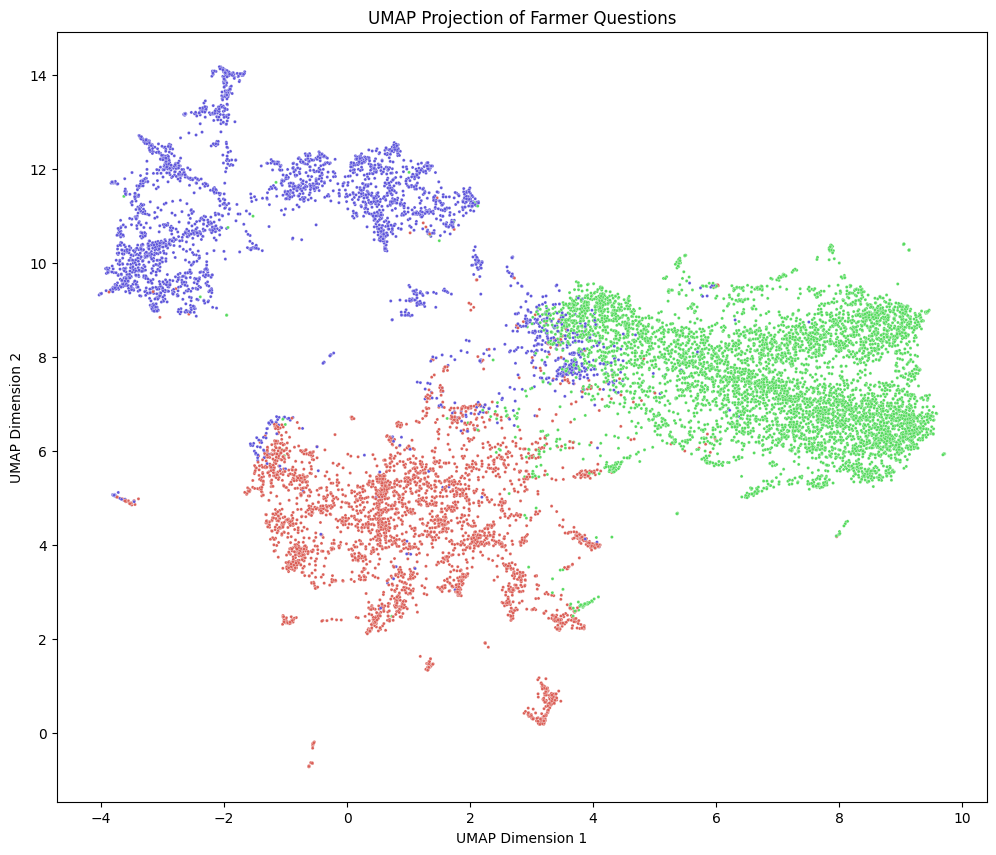

In [ ]:
# Visualization
# 1. Scatter plot
plt.figure(figsize=(12, 10))

sns.scatterplot(
    x='umap_x', 
    y='umap_y', 
    hue='cluster_id', 
    data=sample_df.sample(frac=0.8, random_state=42), 
    palette=sns.color_palette("hls", 3),
    legend=False,
    s=5
)

plt.title('UMAP Projection of Farmer Questions')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.savefig('cluster_visualization.png')
print("Visualization saved as cluster_visualization.png")

# 2. Preparation for manual interpretation
QUESTION_TEXT_COL = 'question_content'
LANGUAGE_COL = 'question_language'
top_clusters = sample_df['cluster_id'].value_counts().nlargest(3).index

print("Inspecting clusters")
for cluster_id in top_clusters:
    cluster_questions = sample_df[sample_df['cluster_id'] == cluster_id]
    
    print(f"\nCluster ID {cluster_id} (Size: {len(cluster_questions):,} questions):")
    
    # Show the language distribution (to verify cross-lingual mixing)
    lang_dist = cluster_questions[LANGUAGE_COL].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    print(f"  Language Mix: {lang_dist.to_dict()}")
    
    # Show the content of the first few questions (manually translate these)
    print("  Top 15 Questions:")
    for i, row in cluster_questions.head(15).iterrows():
        print(f"  - [{row[LANGUAGE_COL].upper()}] {row[QUESTION_TEXT_COL][:80]}...")